In [25]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data
Here the dataset has $x \sim U(-\pi, \pi)\times U(-1.5, 1.5)$. We then generate labels $y$ as $y = \left[\frac{1}{2}\sin(2x_0) < x_1\right]$. 

In [2]:
# 1000 x 2 ==> batch x features
x = th.rand([1000, 2])
x[:, 0] *= 2*pi
x[:, 0] -= pi
x[:, 1] *= 3
x[:, 1] -= 1.5

# Labels
y = (th.sin(x[:, 0] * 2) * 0.5 < x[:, 1]).long()

## Deep Forest

In [26]:
model = deep_forest.DeepForest(25, 2, 2, 1, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
x = x.to(device)
y = y.to(device)

In [27]:
optimizer = th.optim.Adam(model.parameters())
for i in range(2500):
    model.populate_best(x[:, :], y[:])
    optimizer.zero_grad()

    loss = model.loss(x[:, :], y[:], device)
    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print("====EPOCH %d====\nAcc: %s\nLoss: %s" % (i, str(th.mean((model.forward(x[:, :], device) == y[:]).float())), str(loss)))

print("\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(x[:, :], device) == y[:]).float())))

====EPOCH 0====
Acc: tensor(0.6700)
Loss: tensor([107.6632], grad_fn=<AddBackward0>)
====EPOCH 200====
Acc: tensor(0.9160)
Loss: tensor([98.0244], grad_fn=<AddBackward0>)
====EPOCH 400====
Acc: tensor(0.9150)
Loss: tensor([97.6158], grad_fn=<AddBackward0>)
====EPOCH 600====
Acc: tensor(0.9170)
Loss: tensor([97.3641], grad_fn=<AddBackward0>)
====EPOCH 800====
Acc: tensor(0.9270)
Loss: tensor([97.5459], grad_fn=<AddBackward0>)
====EPOCH 1000====
Acc: tensor(0.9350)
Loss: tensor([97.6223], grad_fn=<AddBackward0>)
====EPOCH 1200====
Acc: tensor(0.9470)
Loss: tensor([97.2461], grad_fn=<AddBackward0>)
====EPOCH 1400====
Acc: tensor(0.9640)
Loss: tensor([97.3704], grad_fn=<AddBackward0>)
====EPOCH 1600====
Acc: tensor(0.9720)
Loss: tensor([97.1142], grad_fn=<AddBackward0>)
====EPOCH 1800====
Acc: tensor(0.9750)
Loss: tensor([96.4621], grad_fn=<AddBackward0>)
====EPOCH 2000====
Acc: tensor(0.9770)
Loss: tensor([96.7574], grad_fn=<AddBackward0>)
====EPOCH 2200====
Acc: tensor(0.9780)
Loss: tens

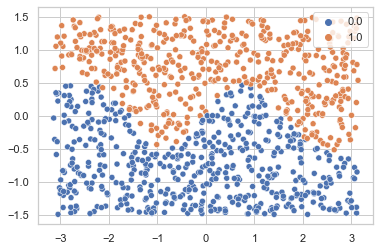

In [28]:
sns.scatterplot(x[:, 0], x[:, 1], hue=model.forward(x, device).cpu().numpy())
plt.show()

## MLP Baseline

In [29]:
mlp = nn.Sequential(
    nn.Linear(2, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 2),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
for i in range(1000):
    optimizer.zero_grad()

    preds = mlp(x[:, :])
    loss = nn.functional.cross_entropy(preds, (y[:].type(th.LongTensor)).to(device))
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print("====EPOCH %d====\nAcc: %s\nLoss: %s" % (i, str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())), str(loss)))

print("\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())))

====EPOCH 0====
Acc: tensor(0.4810)
Loss: tensor(0.6876, grad_fn=<NllLossBackward>)
====EPOCH 100====
Acc: tensor(0.9250)
Loss: tensor(0.4775, grad_fn=<NllLossBackward>)
====EPOCH 200====
Acc: tensor(0.9240)
Loss: tensor(0.3960, grad_fn=<NllLossBackward>)
====EPOCH 300====
Acc: tensor(0.9270)
Loss: tensor(0.3848, grad_fn=<NllLossBackward>)
====EPOCH 400====
Acc: tensor(0.9360)
Loss: tensor(0.3766, grad_fn=<NllLossBackward>)
====EPOCH 500====
Acc: tensor(0.9450)
Loss: tensor(0.3681, grad_fn=<NllLossBackward>)
====EPOCH 600====
Acc: tensor(0.9610)
Loss: tensor(0.3607, grad_fn=<NllLossBackward>)
====EPOCH 700====
Acc: tensor(0.9700)
Loss: tensor(0.3557, grad_fn=<NllLossBackward>)
====EPOCH 800====
Acc: tensor(0.9710)
Loss: tensor(0.3521, grad_fn=<NllLossBackward>)
====EPOCH 900====
Acc: tensor(0.9720)
Loss: tensor(0.3495, grad_fn=<NllLossBackward>)

FINAL ACC: tensor(0.9750)


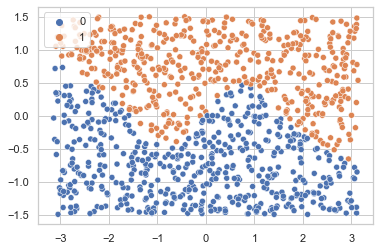

In [30]:
sns.scatterplot(x[:, 0], x[:, 1], hue=th.argmax(mlp(x[:]), 1).cpu().numpy())
plt.show()

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(x[:, :].numpy(), y[:].numpy())
print(clf.score(x[:, :].numpy(), y[:].numpy()))

0.927


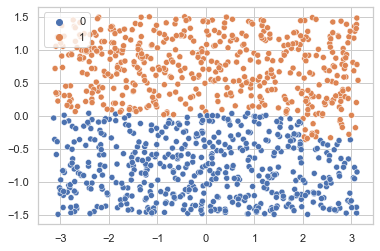

In [32]:
sns.scatterplot(x[:, 0], x[:, 1], hue=clf.predict(x[:, :].numpy()))
plt.show()